In [2]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import everygrams
from nltk.lm.preprocessing import padded_everygram_pipeline
from collections import Counter

from tensorflow.keras.utils import pad_sequences
from collections import Counter
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers = 8)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

2023-08-14 19:10:14.644946: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 19:10:15.254661: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-14 19:10:17.183024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
df = pd.read_csv('../data/processed_data.csv')

In [4]:
df[df.columns[:-3]]

,Unnamed: 0,data
0,0,This show is a great history story. It's has e...
1,1,"A few years ago, a friend got from one of his ..."
2,2,"I like this movie a lot, but it's a fact, that..."
3,3,"A brilliant movie about family, guilt, sacrifi..."
4,4,One of the many Merrie Melodies cartoons that ...
...,...,...
49995,49995,If you are a bit masochistic and like to waste...
49996,49996,'R Xmas is one of the only films I've seen whe...
49997,49997,Ruggero Deodato is often credited for inventin...
49998,49998,"""Stick Around"" is one of the brief series of f..."


In [6]:
sample_df = df.sample(frac=1).iloc[:].reset_index()
sample_df.drop(sample_df.columns[:-3], axis=1, inplace=True)
# sample_df.head()

In [7]:
n_grms = sample_df['preprocessed text'].parallel_apply(lambda a: list(everygrams(a.split(),  max_len=3)))

In [8]:
ngrams = []
for seq in n_grms.to_list():
    ngrams += seq


In [9]:
counter = Counter(ngrams)

In [10]:
non_unigrams = list(filter(lambda a: len(a)>=1, counter))
non_unigrams_counter = {n_gram : counter[n_gram] for n_gram in non_unigrams}
                                    
non_unigrams_counter = pd.DataFrame(non_unigrams_counter.items(), \
                                    index=[' '.join(text) for text in non_unigrams_counter.keys()], columns=['ngram', 'count'])\
                                    .sort_values(by=['count'], ascending=False)
non_unigrams_counter.reset_index(inplace=True)
non_unigrams_counter.drop(columns=['index'], inplace=True)
non_unigrams_counter['ngram_len'] = non_unigrams_counter['ngram'].apply(len)
non_unigrams_counter['ngram'] = non_unigrams_counter['ngram'].parallel_apply(lambda a: ' '.join(a))

In [11]:
non_unigrams_counter

,ngram,count,ngram_len
0,br,201930,1
1,br br,101263,2
2,movie,86187,1
3,film,78076,1
4,not,62226,1
...,...,...,...
7882167,compelling horror entry,1,3
7882168,quite compelling horror,1,3
7882169,would quite compelling,1,3
7882170,logic would quite,1,3


In [12]:
non_unigrams_counter['count'].sum()

17430039

In [13]:
non_unigrams_counter['freq'] = non_unigrams_counter['count'] / non_unigrams_counter['count'].sum()
non_unigrams_counter['log_freq'] = non_unigrams_counter['freq'].parallel_apply(np.log10)
non_unigrams_counter['log_abs_log_freq'] = non_unigrams_counter['log_freq'].parallel_apply(lambda a: np.log10(np.abs(a)))

In [14]:
non_unigrams_counter.describe()

,count,ngram_len,freq,log_freq,log_abs_log_freq
count,7.882172e+06,7.882172e+06,7.882172e+06,7.882172e+06,7.882172e+06
mean,2.211324e+00,2.644578e+00,1.268686e-07,-7.181491e+00,8.560052e-01
std,1.111631e+02,4.844350e-01,6.377675e-06,2.096408e-01,1.393600e-02
min,1.000000e+00,1.000000e+00,5.737222e-08,-7.241298e+00,2.869272e-01
25%,1.000000e+00,2.000000e+00,5.737222e-08,-7.241298e+00,8.598164e-01
50%,1.000000e+00,3.000000e+00,5.737222e-08,-7.241298e+00,8.598164e-01
75%,1.000000e+00,3.000000e+00,5.737222e-08,-7.241298e+00,8.598164e-01
max,2.019300e+05,3.000000e+00,1.158517e-02,-1.936098e+00,8.598164e-01


In [15]:
def plot_ngram_stat(col_to_plot, data):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(15, 10)
    for col in col_to_plot:
        axs[0].hist(data[col].values, bins=50, label=col)

    axs[1].boxplot(data[col_to_plot].values, labels = col_to_plot)
    # axs[1].boxplot(non_unigrams_counter['count'].values)
    axs[0].grid()
    axs[0].legend()
    axs[1].grid()

([<matplotlib.patches.Wedge at 0x7fca44bdbd00>,
 [Text(1.0999577431334786, 0.009641748840549715, '1'),
  Text(0.48262436714056806, 0.9884703942163197, '2'),
  Text(-0.49127008428831137, -0.9842020647627985, '3')],
 [Text(0.5999769508000792, 0.005259135731208934, '0%'),
  Text(0.2632496548039462, 0.539165669572538, '35%'),
  Text(-0.26796550052089707, -0.5368374898706173, '65%')])

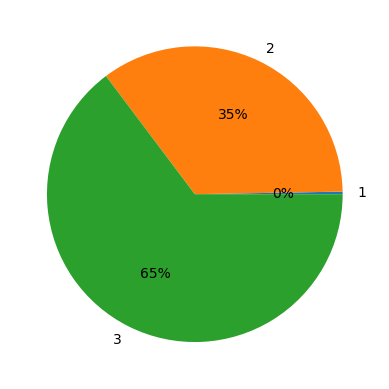

In [16]:
n_gram_count = Counter(non_unigrams_counter['ngram_len'].values)
plt.pie(n_gram_count.values(), labels = n_gram_count.keys(), autopct='%.0f%%')

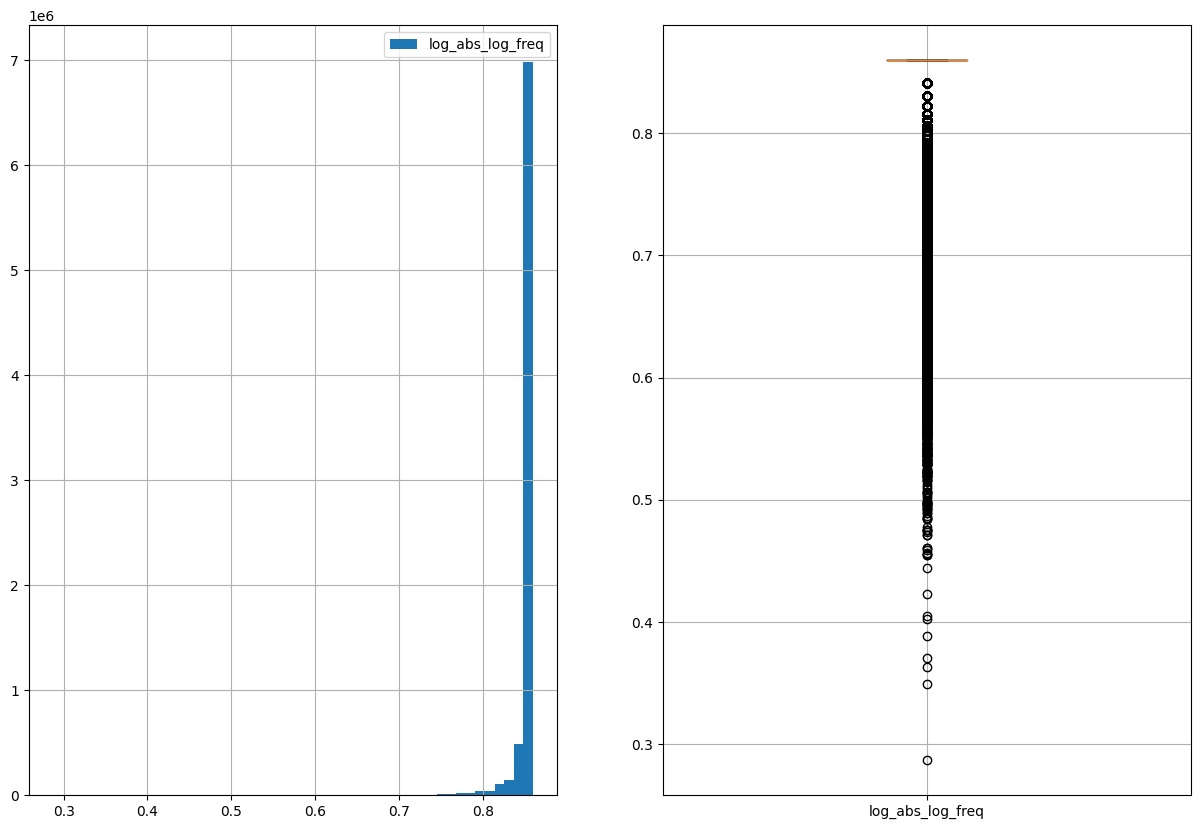

In [17]:
plot_ngram_stat(non_unigrams_counter.columns[5:], non_unigrams_counter)

In [18]:
min_threshold_count_ngram, max_threshold_count_ngram = 50, 100_000

In [19]:
ngrams_to_filter = non_unigrams_counter[((non_unigrams_counter['count'] < min_threshold_count_ngram) | (non_unigrams_counter['count'] > max_threshold_count_ngram )) & (non_unigrams_counter['ngram_len'] > 1)]
filtred_non_unigrams_counter = non_unigrams_counter.drop(ngrams_to_filter.index,axis=0, inplace=False)


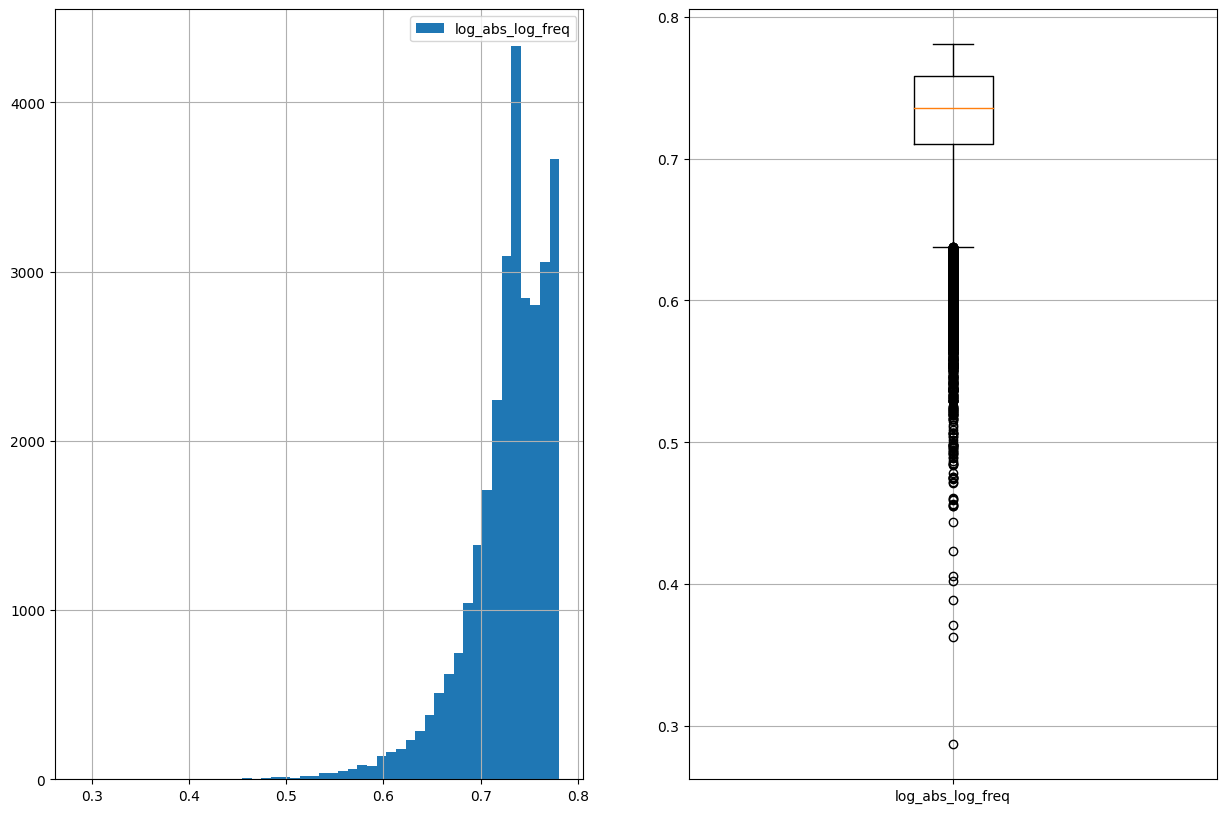

In [20]:
plot_ngram_stat(non_unigrams_counter.columns[5:], filtred_non_unigrams_counter)

In [21]:
filtred_non_unigrams_counter.describe()

,count,ngram_len,freq,log_freq,log_abs_log_freq
count,29862.000000,29862.000000,2.986200e+04,29862.000000,29862.000000
mean,230.062990,1.295124,1.319922e-05,-5.366287,0.727643
std,1692.754636,0.520761,9.711709e-05,0.494556,0.043127
min,16.000000,1.000000,9.179555e-07,-6.037178,0.286927
25%,32.000000,1.000000,1.835911e-06,-5.736148,0.710177
50%,63.000000,1.000000,3.614450e-06,-5.441958,0.735755
75%,129.000000,2.000000,7.401016e-06,-5.130709,0.758620
max,201930.000000,3.000000,1.158517e-02,-1.936098,0.780834


([<matplotlib.patches.Wedge at 0x7fca090ab100>,
 [Text(-0.744023361416135, 0.8102032076380811, '1'),
  Text(0.6601189200339699, -0.87991079741823, '2'),
  Text(1.094591320481283, -0.10894880048463902, '3')],
 [Text(-0.4058309244088009, 0.44192902234804415, '74%'),
  Text(0.3600648654730745, -0.4799513440463072, '23%'),
  Text(0.5970498111716088, -0.05942661844616673, '3%')])

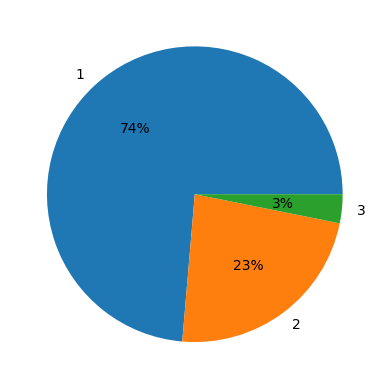

In [22]:
n_gram_count = Counter(filtred_non_unigrams_counter['ngram_len'].values)
plt.pie(n_gram_count.values(), labels = n_gram_count.keys(), autopct='%.0f%%')

# Написание фунций обработки текстов. Токенизация текста N-gram 1-3

<ol>
    <li>Токенизация текста</li>
    <li>Отчистка от стопслов и пунктуации</li>
    <li>Выделение в текстах n-gram</li>
</ol>

In [24]:
sys.path[0]

NameError: name 'sys' is not defined

In [26]:
# sys.path[0] += '/green'

In [27]:
# if __name__ == '__main__':
#     import sys
#     sys.path[0] = '/'.join(sys.path[0].split('/')[:-1])

In [28]:
# sys.path[0] = sys.path[0].replace('green_atom', '/green_atom')

In [29]:
tokens = {
    token : i for i, token in enumerate(filtred_non_unigrams_counter.sort_values('ngram')['ngram'], 1)
}
tokens

{'<bos>': 1,
 '<bos> absolutely': 2,
 '<bos> actually': 3,
 '<bos> admit': 4,
 '<bos> agree': 5,
 '<bos> almost': 6,
 '<bos> although': 7,
 '<bos> always': 8,
 '<bos> another': 9,
 '<bos> anyone': 10,
 '<bos> awful': 11,
 '<bos> bad': 12,
 '<bos> based': 13,
 '<bos> believe': 14,
 '<bos> best': 15,
 '<bos> big': 16,
 '<bos> big fan': 17,
 '<bos> bought': 18,
 '<bos> br': 19,
 '<bos> br br': 20,
 '<bos> caught': 21,
 '<bos> could': 22,
 '<bos> definitely': 23,
 '<bos> despite': 24,
 '<bos> director': 25,
 '<bos> documentary': 26,
 '<bos> enjoyed': 27,
 '<bos> even': 28,
 '<bos> ever': 29,
 '<bos> every': 30,
 '<bos> excellent': 31,
 '<bos> fan': 32,
 '<bos> far': 33,
 '<bos> film': 34,
 '<bos> finally': 35,
 '<bos> finished': 36,
 '<bos> first': 37,
 '<bos> first let': 38,
 '<bos> first saw': 39,
 '<bos> first time': 40,
 '<bos> found': 41,
 '<bos> friend': 42,
 '<bos> funny': 43,
 '<bos> gave': 44,
 '<bos> get': 45,
 '<bos> give': 46,
 '<bos> going': 47,
 '<bos> good': 48,
 '<bos> got'

In [30]:
from dataprocess import DataPreProcesser

In [31]:
data_preprocesser = DataPreProcesser(10_000)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/argen7um/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
split_by_space = lambda a: a.split()
get_n_gram_from_seq = lambda a: list(everygrams(split_by_space(a), max_len=3))
sample_df['preprocessed text'].iloc[:10].parallel_apply(get_n_gram_from_seq)

0    [(<bos>,), (<bos>, pointless), (<bos>, pointle...
1    [(<bos>,), (<bos>, action), (<bos>, action, cl...
2    [(<bos>,), (<bos>, valentine), (<bos>, valenti...
3    [(<bos>,), (<bos>, films), (<bos>, films, badl...
4    [(<bos>,), (<bos>, movie), (<bos>, movie, one)...
5    [(<bos>,), (<bos>, alien), (<bos>, alien, exce...
6    [(<bos>,), (<bos>, last), (<bos>, last, weeken...
7    [(<bos>,), (<bos>, shame), (<bos>, shame, rath...
8    [(<bos>,), (<bos>, truly), (<bos>, truly, kung...
9    [(<bos>,), (<bos>, atlantis), (<bos>, atlantis...
Name: preprocessed text, dtype: object

In [ ]:
seq = sample_df['preprocessed text'].iloc[0]
seq = [' '.join(token) for token in get_n_gram_from_seq(seq)]

In [33]:
def preprocess_ngram(seq):
    seq = everygrams(seq.split(), max_len=3)
    return [tokens.get(' '.join(token)) for token in seq if tokens.get(' '.join(token)) is not None]    


In [34]:
sample_df['encoded text'] = sample_df['preprocessed text'].parallel_apply(preprocess_ngram)

In [35]:
max_lenth = sample_df['encoded text'].apply(len).max()

In [36]:
sample_df['padded sequences'] = pad_sequences(sample_df['encoded text'], max_lenth, padding='pre', value=0).tolist()
sample_df['padded sequences']

0        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
49995    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49996    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49997    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49998    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49999    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: padded sequences, Length: 50000, dtype: object

In [37]:
sample_df.drop(columns = ['cleaned text'], inplace=True)


In [38]:
sample_df.to_csv('../data/ngram_processed_text.csv')

In [ ]:
sample_df['padded sequences'][0]

array([    0,     0,     0, ..., 14929, 14957, 10810], dtype=int32)